Introduction to Maps and Spatial Data
======================================
These examples use the `GeoPandas` package which adds special
functions for `DataFrame`s to work with geographic data.

There are two basic ways to visualize the data spatial data (aka make maps):
`plot()` and `explore()`. `plot()` creates a `matplotlib` chart of the data, `explore()` creates an interactive map with the shapes overlayed on open map data.

For the visualizations to work, though, you have to set a relevant index on the data. In our case here, the index is the district number.

After the basic plots, we merge the school district data with the school demographics data in order to create more detailed examples.

Useful links:

- [`geopandas`](https://geopandas.org/en/stable/index.html)
- [`matplotlib` color maps](https://matplotlib.org/stable/tutorials/colors/colormaps.html)



In [ ]:
# uncomment and run if using Google Colab

# !pip install geopandas
# !pip install nycschools
# from nycschools import dataloader
# dataloader.download_data()

In [8]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown as md

from nycschools import schools, geo, ui

GeoDataFrame
------------
`GeoDataFrame` adds geospatial data to a regular `pandas` `DataFrame`. The specially named `geometry` column is used to plot the spatial data on a map.

In [4]:
# read the GeoJSON file directly from the download link
gdf = geo.load_districts()
# each shape in "geometry" represents a district
gdf = gdf.set_index("district")
gdf.head()

area         length  \
district                                 
32        51898496.7618  37251.0574964   
16        46763620.3794  35848.9043428   
17        128440514.645  68356.1032412   
13        104871082.804  86649.0984086   
25         443759165.29  176211.272136   

                                                   geometry  
district                                                     
32        MULTIPOLYGON (((-73.91181 40.70343, -73.91290 ...  
16        MULTIPOLYGON (((-73.93312 40.69579, -73.93237 ...  
17        MULTIPOLYGON (((-73.92044 40.66563, -73.92061 ...  
13        MULTIPOLYGON (((-73.97906 40.70595, -73.97924 ...  
25        MULTIPOLYGON (((-73.82050 40.80101, -73.82040 ...

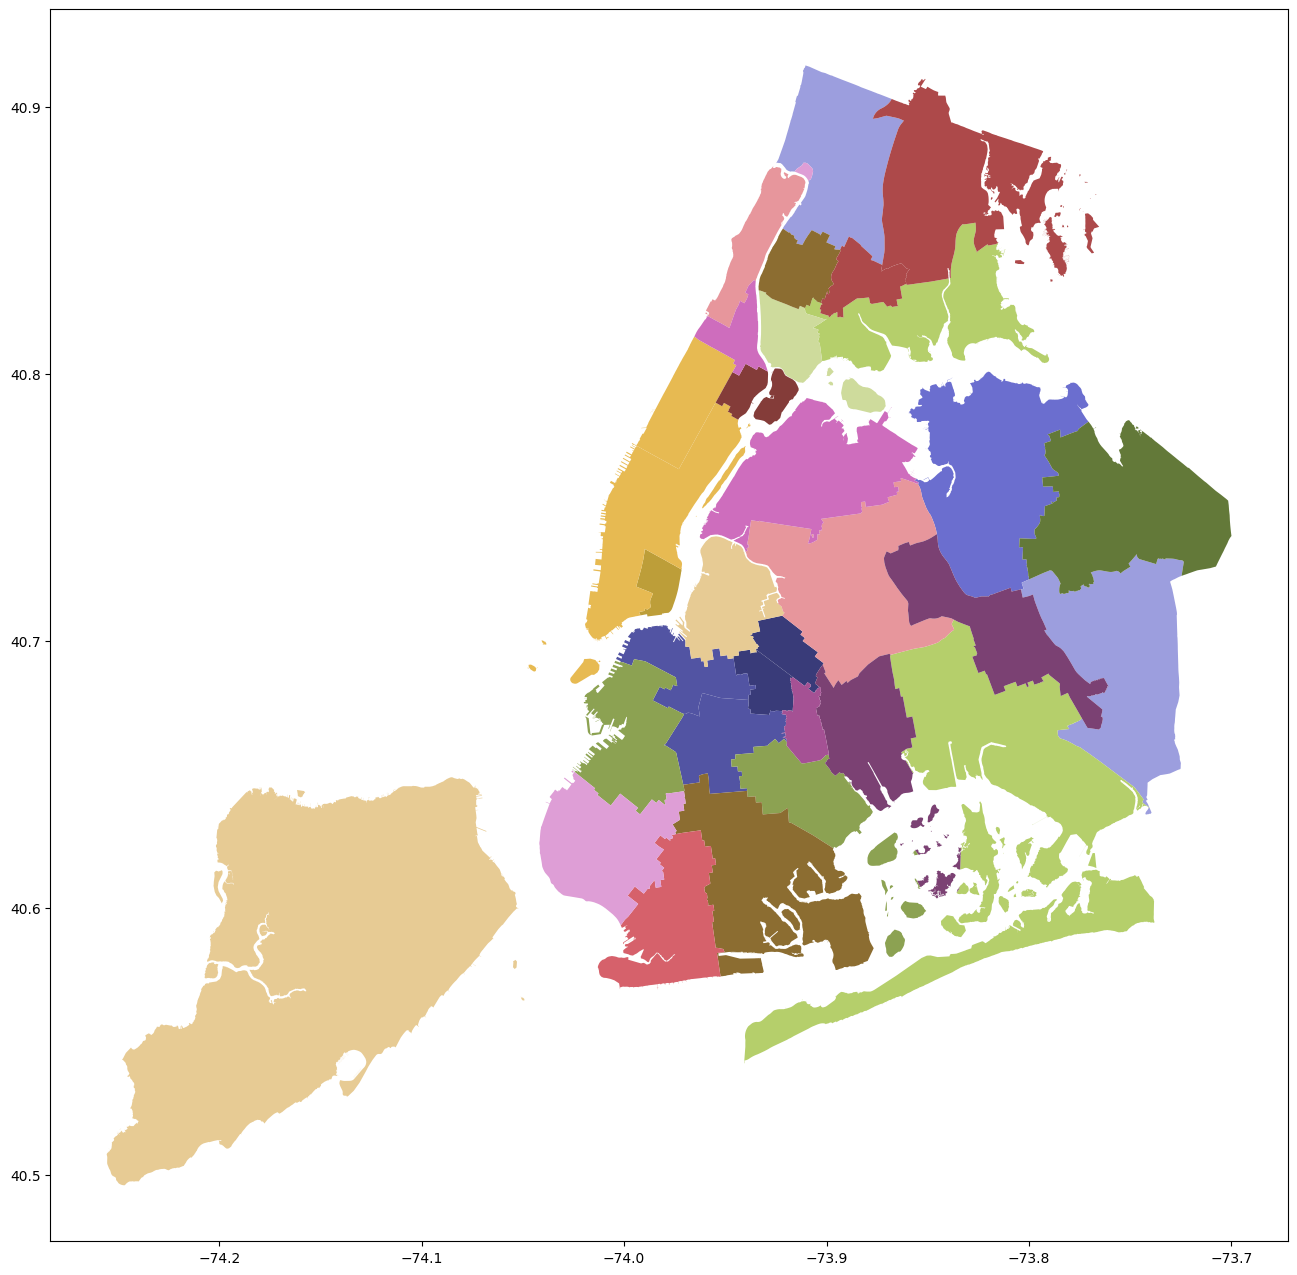

In [5]:
# draw the basic map using the tab20b color map
_ = gdf.plot(figsize=(16, 16), cmap="tab20b")

In [12]:
# explore gives us an interactive map
# non-geo columns show up when you hover over a shape
gdf.explore()

Merging School Data with Geo Data
---------------------------------

In [6]:
# load the demographics
# group the data at the district level
# merge the two dataframes on the district

dist_map = gdf.copy()

demo = schools.load_school_demographics()
demo = demo.query(f"ay == {demo.ay.max()}")
aggs = {
    'total_enrollment': 'sum',
    'asian_pct': 'mean',
    'black_pct': 'mean',
    'hispanic_pct': 'mean',
    'white_pct': 'mean',
    'swd_pct': 'mean',
    'ell_pct': 'mean',
    'poverty_pct': 'mean'
}
demo = demo.groupby("district").agg(aggs)


cols = [c for c in demo.columns if c.endswith("pct")]
for col in cols:
    demo[col]= demo[col].apply(lambda x: f"{round(x*100, 2)}")

dist_map = dist_map.reset_index()
dist_map.district = pd.to_numeric(dist_map.district, downcast='integer', errors='coerce')


dist_map = dist_map.join(demo, on="district", how="inner")
dist_map = dist_map.set_index("district")


dist_map = dist_map[['geometry', 'total_enrollment', 'asian_pct',
       'black_pct', 'hispanic_pct', 'white_pct', 'swd_pct', 'ell_pct',
       'poverty_pct']]
dist_map.head()

geometry  total_enrollment  \
district                                                                        
32        MULTIPOLYGON (((-73.91181 40.70343, -73.91290 ...              9831   
16        MULTIPOLYGON (((-73.93312 40.69579, -73.93237 ...              7127   
17        MULTIPOLYGON (((-73.92044 40.66563, -73.92061 ...             20628   
13        MULTIPOLYGON (((-73.97906 40.70595, -73.97924 ...             24564   
25        MULTIPOLYGON (((-73.82050 40.80101, -73.82040 ...             38992   

         asian_pct black_pct hispanic_pct white_pct swd_pct ell_pct  \
district                                                              
32            1.97     15.87        78.73      2.61   21.46   24.09   
16             2.4     68.88        21.85      4.72   27.09    5.87   
17            3.23     72.76         17.7      3.67   21.67   10.56   
13            6.45     54.65        22.49     12.66   20.81     6.3   
25           49.74      6.43        30.36     11.21    15.4   20.81   

         poverty_pct  
district              
32             87.66  
16             86.54  
17             83.58  
13              69.2  
25             68.98

Use a column to color a choropleth
-----------------------------------
Choropleths use colored region to help visualize spatial data. The map below uses the average percent poverty in each of the 32 community school districts to help visual relative wealth of the different districts in NYC Schools. The area of each district is colored using a divergent cool-warm color map. Darkest blue districts have the lowest average poverty rate and darkest red have the highest rate.

### Choropleth of school poverty

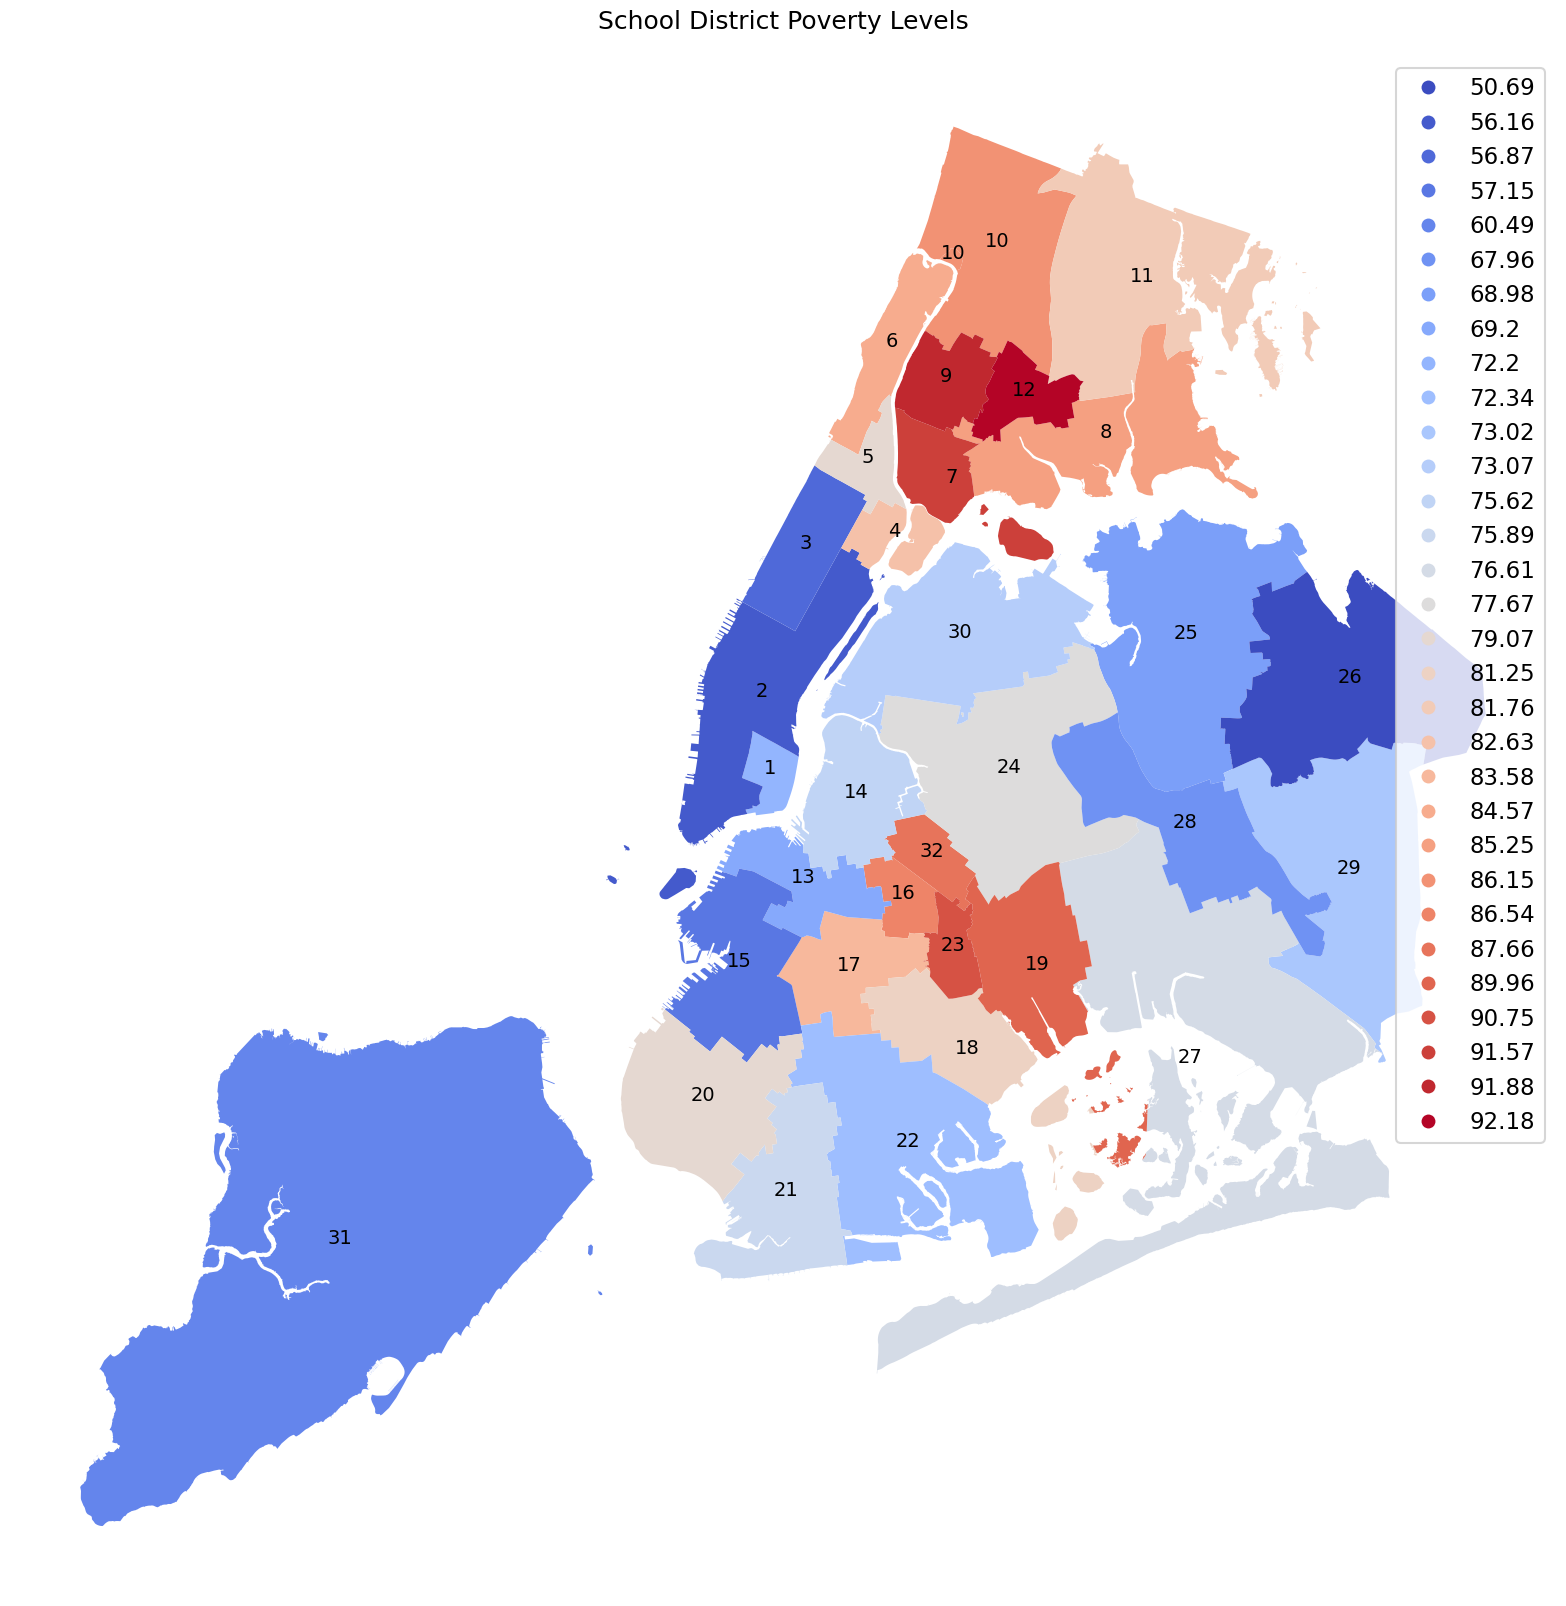

In [9]:
# make a plot that uses the poverty percent as a the value for the color map
# this is the `column` keyword argument for plot()

fig, ax = plt.subplots(figsize=(16, 16))
sns.set_context('talk')

# don't show the boundary box or x/y ticks
plt.axis('off')
fig.tight_layout()

ax.set_title('School District Poverty Levels', pad=20)

# put the district number in the center of each district
def label(row):
    xy=row.geometry.centroid.coords[0]
    ax.annotate(row.name, xy=xy, ha='center', fontsize=14)
dist_map.apply(label, axis=1)

_ = dist_map.plot(legend="True", ax=ax, column="poverty_pct", cmap="coolwarm")


### Choropleth of school district enrollment

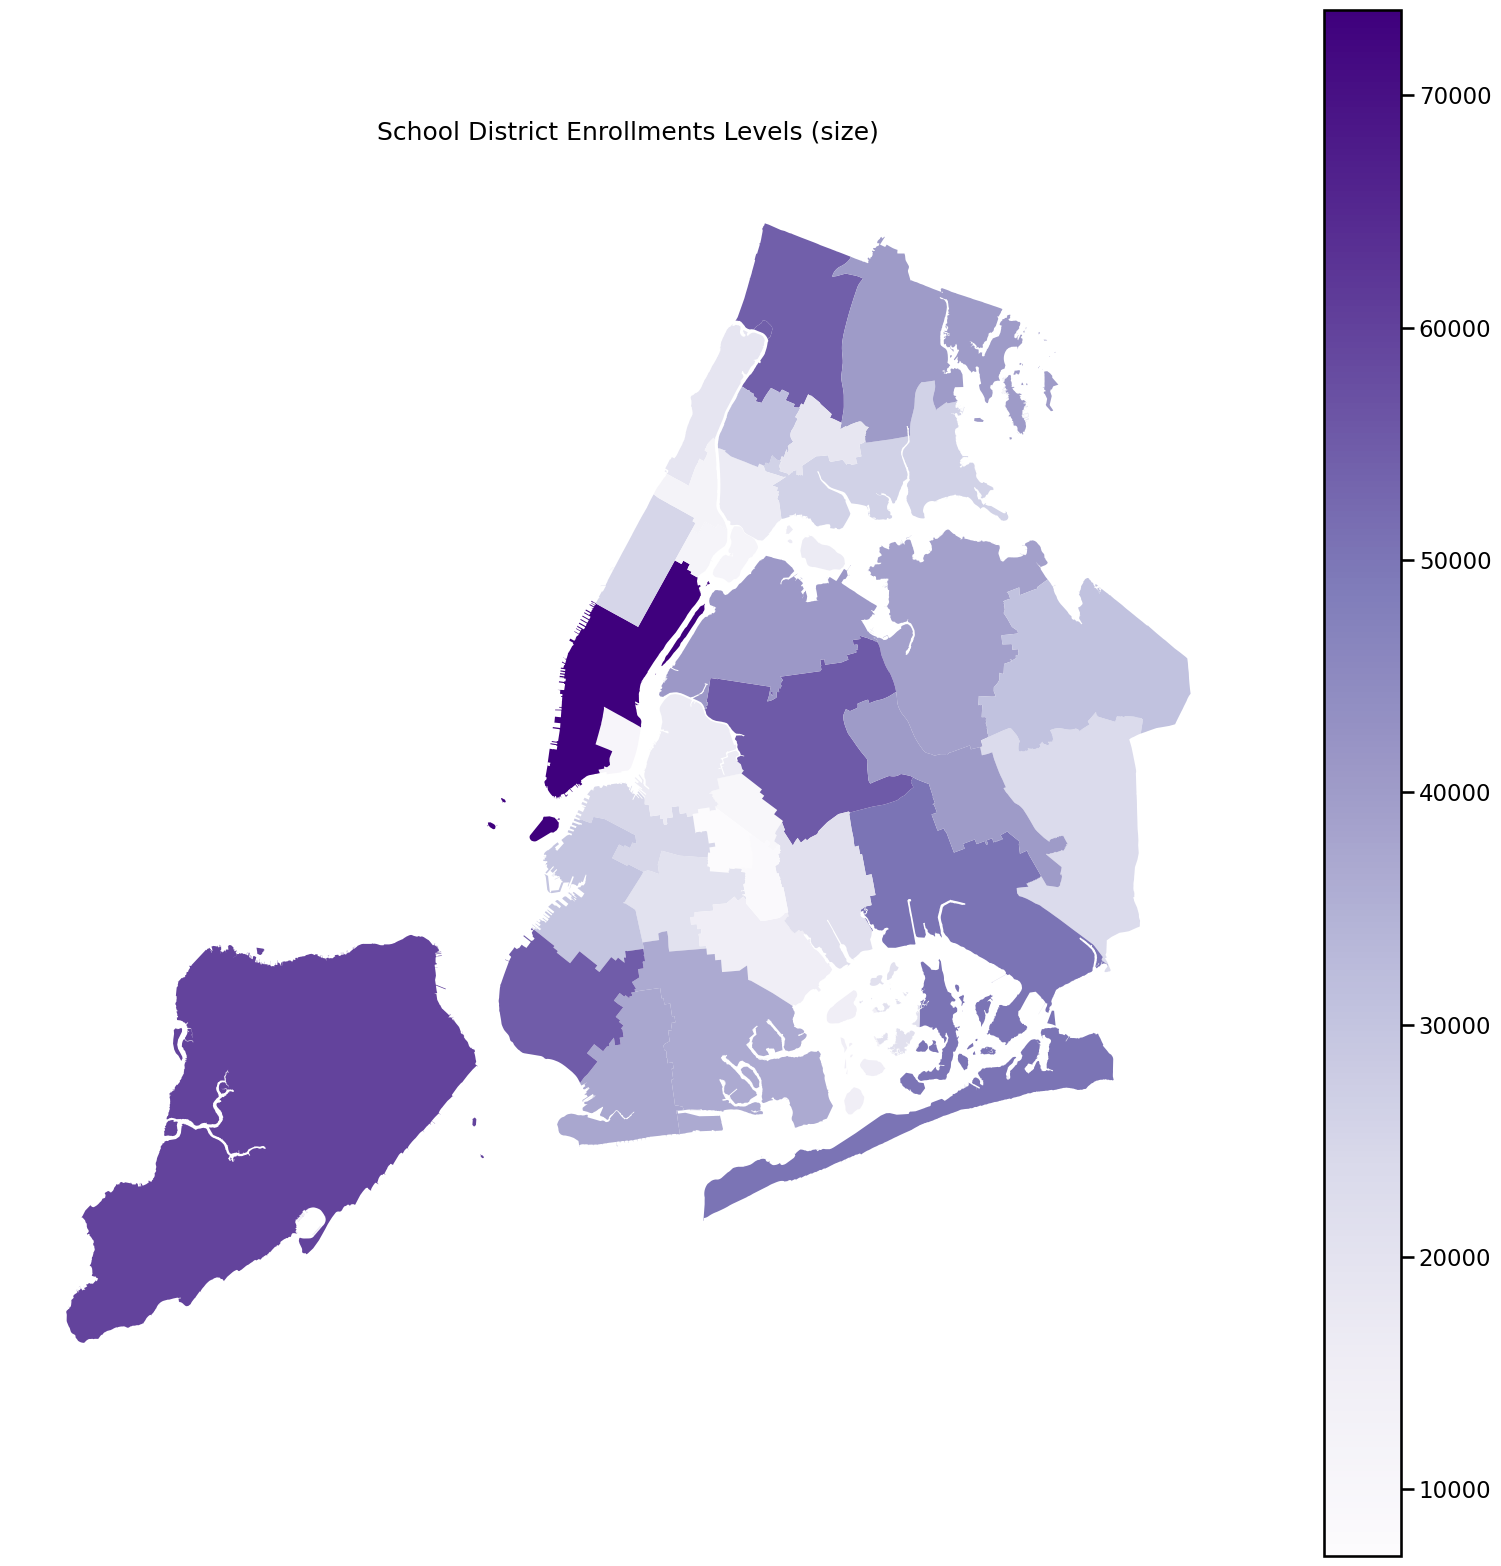

In [13]:
# if we pass a different column, we can create a different plot
fig, ax = plt.subplots(figsize=(16, 16))
sns.set_context('talk')
plt.axis('off')
fig.tight_layout()
ax.set_title('School District Enrollments Levels (size)', pad=20)

dist_map.plot(legend="True", ax=ax, column="total_enrollment", cmap="Purples")
plt.show()


Chlorpleths in Folium
----------------------
The geopandas `explore()` methos also has a column keyword that lets us draw a Folium map.
Below we show the districts by poverty level. Mouse over and you can see all of the demographic data for the district as a pop-up.

In [14]:

dist_map.explore(column="poverty_pct", cmap="coolwarm")